## Análise exploratória dos dados, treinamento, validação e teste da rede neural MLP no Dataset Titanic - Terceira Avaliação Redes Neurais
### Discente: João Pedro de Alcântara Lima

Neste trabalho, foi desenvolvido um pipeline completo de análise e modelagem preditiva utilizando o dataset do Titanic, com o objetivo de prever a sobrevivência dos passageiros a partir de variáveis disponíveis. O processo envolveu diversas etapas, desde a análise exploratória dos dados até a avaliação detalhada do desempenho do modelo de rede neural MLP.

#### 1. Análise Exploratória dos Dados

A análise exploratória foi fundamental para compreender a distribuição das variáveis e suas relações com a variável alvo (`Survived`). Foram geradas tabelas e gráficos para investigar a taxa de sobrevivência em função do sexo (`Sex`), classe (`Pclass`), idade (`Age`), local de embarque (`Embarked`), entre outros fatores. Observou-se, por exemplo, que mulheres e passageiros da primeira classe apresentaram maiores taxas de sobrevivência. Também foram analisadas as distribuições de variáveis como `SibSp`, `Parch`, `Fare` e `Cabin`, além de cruzamentos entre variáveis para identificar padrões e possíveis desbalanceamentos.

Contagem absoluta de sobreviventes por sexo:
Survived    0    1
Sex               
female     81  233
male      468  109

Percentual de sobreviventes por sexo:
Survived          0          1
Sex                           
female    25.796178  74.203822
male      81.109185  18.890815


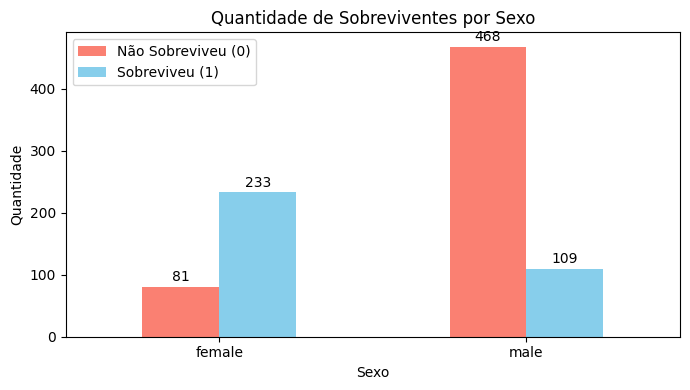

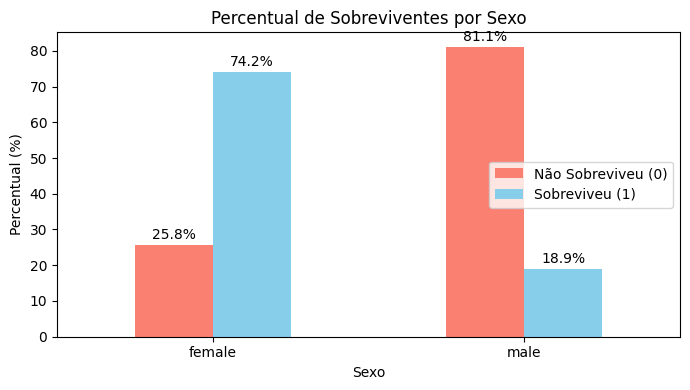

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# 1. Análise quantitativa e relativa de Survived em relação ao Sex
survived_sex_counts = train_df.groupby('Sex')['Survived'].value_counts().unstack().fillna(0)
survived_sex_percent = survived_sex_counts.div(survived_sex_counts.sum(axis=1), axis=0) * 100

print("Contagem absoluta de sobreviventes por sexo:")
print(survived_sex_counts)
print("\nPercentual de sobreviventes por sexo:")
print(survived_sex_percent)

# Plotagem da quantidade absoluta
ax1 = survived_sex_counts.plot(kind='bar', figsize=(7,4), color=['salmon', 'skyblue'])
plt.title('Quantidade de Sobreviventes por Sexo')
plt.ylabel('Quantidade')
plt.xlabel('Sexo')
plt.xticks(rotation=0)
for container in ax1.containers:
    ax1.bar_label(container, padding=2)
plt.legend(['Não Sobreviveu (0)', 'Sobreviveu (1)'])
plt.tight_layout()
plt.show()

# Plotagem do percentual
ax2 = survived_sex_percent.plot(kind='bar', figsize=(7,4), color=['salmon', 'skyblue'])
plt.title('Percentual de Sobreviventes por Sexo')
plt.ylabel('Percentual (%)')
plt.xlabel('Sexo')
plt.xticks(rotation=0)
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.1f%%', padding=2)
plt.legend(['Não Sobreviveu (0)', 'Sobreviveu (1)'])
plt.tight_layout()
plt.show()

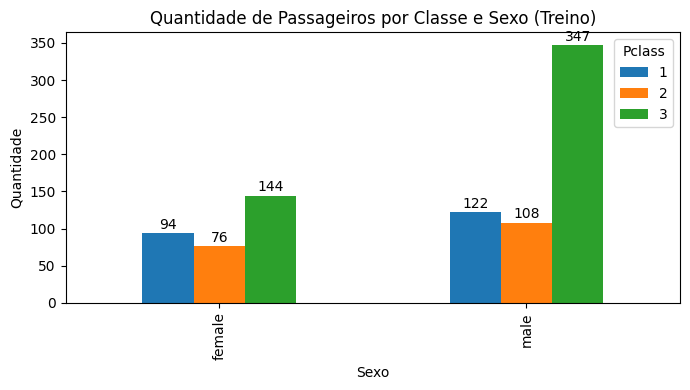

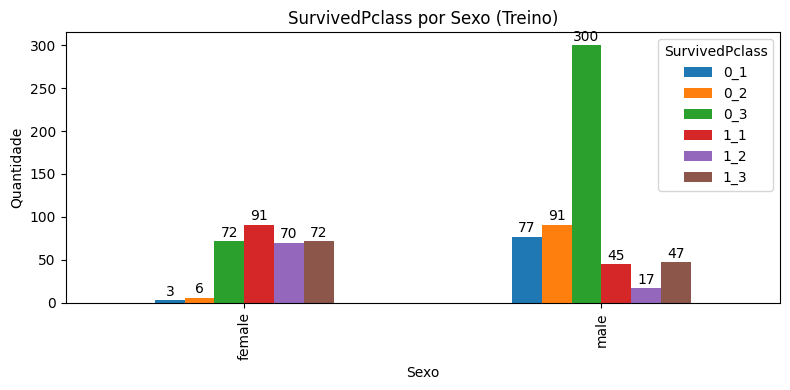

In [21]:
ct = pd.crosstab(train_df['Sex'], train_df['Pclass'])

fig, ax = plt.subplots(figsize=(7,4))
bars = ct.plot(kind='bar', ax=ax) 

plt.title('Quantidade de Passageiros por Classe e Sexo (Treino)')
plt.ylabel('Quantidade')
plt.xlabel('Sexo')

# Adicionar rótulos de dados em cada barra
for container in ax.containers:
    ax.bar_label(container, padding=1)

plt.legend(title='Pclass')
plt.tight_layout()
plt.show()

# 3. Criar a nova classe combinada SurvivedPclass
train_df['SurvivedPclass'] = train_df['Survived'].astype(str) + '_' + train_df['Pclass'].astype(str)

ct = pd.crosstab(train_df['Sex'], train_df['SurvivedPclass'])

fig, ax = plt.subplots(figsize=(8,4))
bars = ct.plot(kind='bar', ax=ax) 

plt.title('SurvivedPclass por Sexo (Treino)')
plt.ylabel('Quantidade')
plt.xlabel('Sexo')

# Adicionar rótulos de dados em cada barra
for container in ax.containers:
    ax.bar_label(container, padding=1)

plt.legend(title='SurvivedPclass')
plt.tight_layout()
plt.show()

#### 2. Pré-processamento e Balanceamento das Classes

O pré-processamento incluiu a limpeza dos dados, tratamento de valores ausentes (como preenchimento de idades e tarifas faltantes com a mediana), e a codificação de variáveis categóricas. Em seguida, os dados foram divididos em conjuntos de treino (80%) e validação (20%), garantindo a estratificação da variável alvo. Para lidar com o desbalanceamento das classes, foi utilizado o método RandomOverSampler, que equilibrou as amostras das classes majoritária e minoritária no conjunto de treino, evitando viés do modelo.


#### 3. Treinamento, Validação e Ajuste de Hiperparâmetros da Rede Neural MLP

O modelo de rede neural MLP foi treinado com os dados balanceados e padronizados, utilizando uma camada oculta e diferentes configurações de hiperparâmetros. O ajuste fino dos hiperparâmetros foi realizado com GridSearchCV, testando diferentes tamanhos de camada oculta, funções de ativação e número de épocas. Durante o treinamento, foram monitoradas as curvas de loss (função de perda) tanto no treino quanto na validação, permitindo identificar o comportamento do modelo e possíveis sinais de overfitting ou underfitting.

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

# Seleção de features
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = train_df[features].copy()
y = train_df['Survived']

# Codificação de variáveis categóricas
X = pd.get_dummies(X, columns=['Sex', 'Embarked'], drop_first=True)
X['Age'] = X['Age'].fillna(X['Age'].median())
X['Fare'] = X['Fare'].fillna(X['Fare'].median())

# 1. Separar em treino (80%) e teste (20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Balanceamento de classes usando RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_bal_scaled = scaler.fit_transform(X_train_bal)
X_val_scaled = scaler.transform(X_val)

# 2. Ajuste de hiperparâmetros com GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(5,), (8,), (10,), (16,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'max_iter': [100, 300, 500],
    'learning_rate_init': [0.001, 0.01]
}
mlp = MLPClassifier(random_state=42)
grid = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid.fit(X_train_bal_scaled, y_train_bal)
print("Melhores hiperparâmetros encontrados:", grid.best_params_)

# Treinamento do modelo final com os melhores hiperparâmetros
best_mlp = grid.best_estimator_
best_mlp.fit(X_train_bal_scaled, y_train_bal)

train_loss = best_mlp.loss_curve_
val_loss = []
for i in range(1, len(train_loss)+1):
    mlp_partial = MLPClassifier(
        hidden_layer_sizes=best_mlp.hidden_layer_sizes,
        activation=best_mlp.activation,
        solver=best_mlp.solver,
        max_iter=i,
        random_state=42,
        warm_start=True
    )
    mlp_partial.fit(X_train_bal_scaled, y_train_bal)
    y_val_pred_proba = mlp_partial.predict_proba(X_val_scaled)
    val_loss.append(log_loss(y_val, y_val_pred_proba))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Melhores hiperparâmetros encontrados: {'activation': 'relu', 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'adam'}


C:\Users\C18270Q\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\C18270Q\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\C18270Q\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\C18270Q\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  warnings.wa

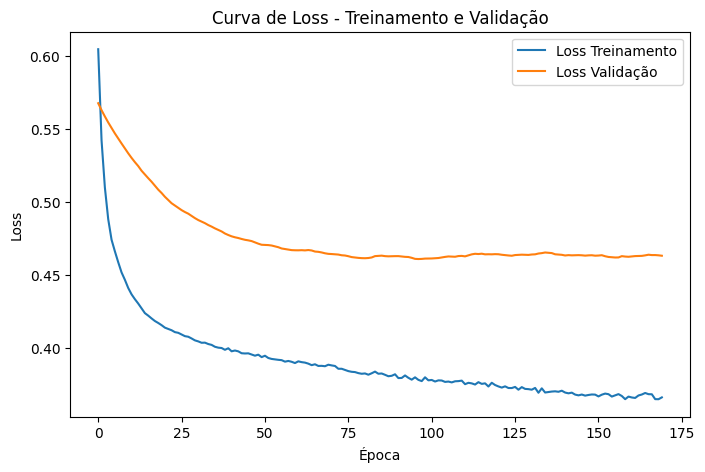

In [23]:
# 3. Plotar curva de loss (treinamento e validação)
plt.figure(figsize=(8,5))
plt.plot(train_loss, label='Loss Treinamento')
plt.plot(val_loss, label='Loss Validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Curva de Loss - Treinamento e Validação')
plt.legend()
plt.show()

#### 4. Avaliação do Modelo

A avaliação do modelo foi conduzida no conjunto de validação, utilizando métricas como acurácia, precisão, recall, F1-score e matriz de confusão. Também foi analisada a curva ROC e o valor da AUC para avaliar a capacidade discriminativa do modelo. Foram identificados os principais tipos de erro (falsos positivos e falsos negativos) e analisados exemplos concretos desses erros, além de calcular a acurácia segmentada por grupos, como sexo dos passageiros. A importância das variáveis foi avaliada a partir dos pesos da primeira camada da rede, destacando quais atributos mais influenciaram as decisões do modelo.

In [24]:
from sklearn.metrics import classification_report

# Avaliação no conjunto de validação
val_pred = best_mlp.predict(X_val_scaled)
print(classification_report(y_val, val_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81       110
           1       0.70      0.71      0.71        69

    accuracy                           0.77       179
   macro avg       0.76      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179



#### 5. Testes e Análises Adicionais

Após a validação, o modelo foi aplicado ao conjunto de teste para prever a sobrevivência dos passageiros. Diversas análises complementares foram realizadas, como a identificação das cabines com maior proporção de sobreviventes, locais de embarque mais favoráveis em cada classe, e faixas de preço da passagem (`Fare`) e idade (`Age`) que mais impactaram a sobrevivência. Foram gerados gráficos para visualizar a influência dessas variáveis e entender melhor o comportamento do modelo. Por fim, foram analisados os erros do modelo por meio de heatmaps e contagens, permitindo identificar padrões nos casos em que o modelo apresentou maior dificuldade.

Previsões de sobrevivência adicionadas ao conjunto de teste:
   Predicted_Survived
0                   0
1                   1
2                   0
3                   0
4                   0


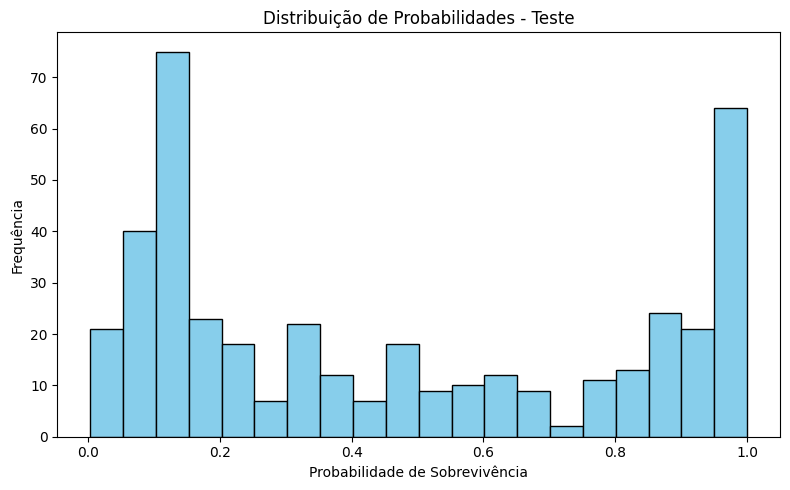

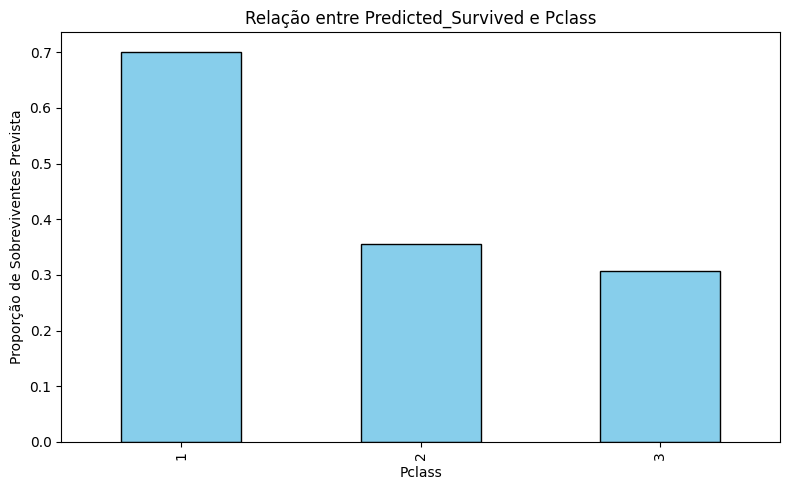

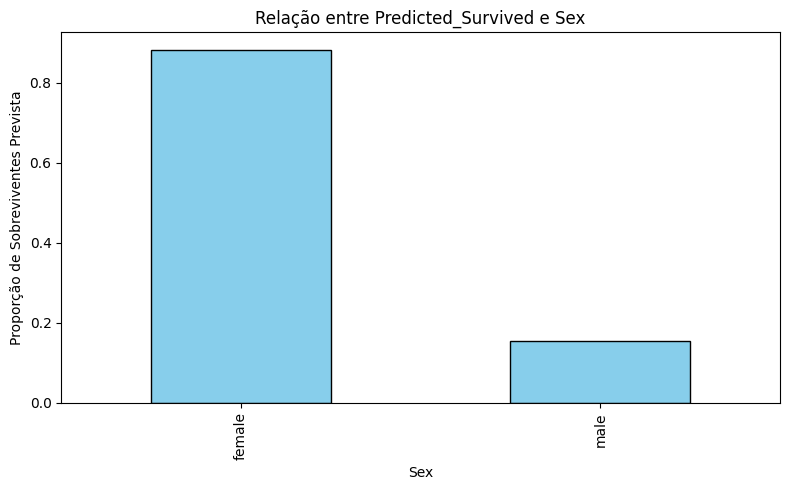

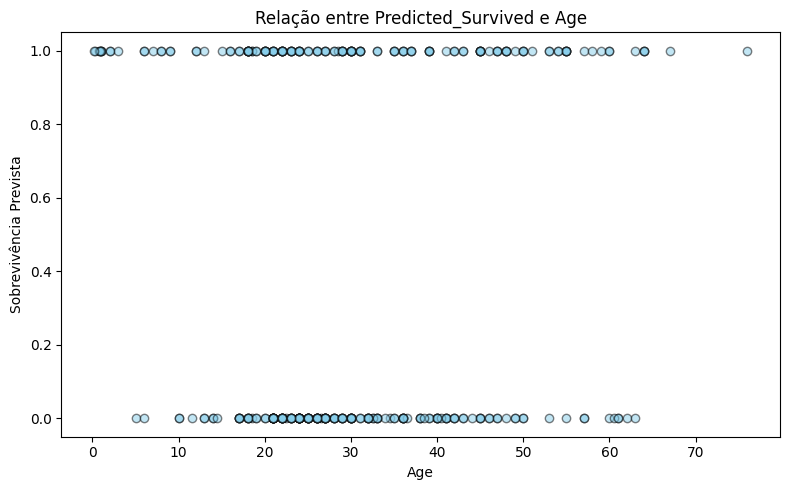

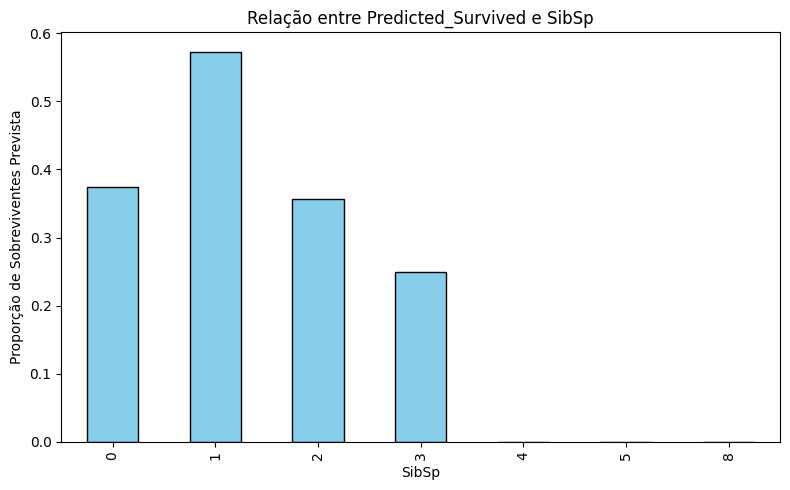

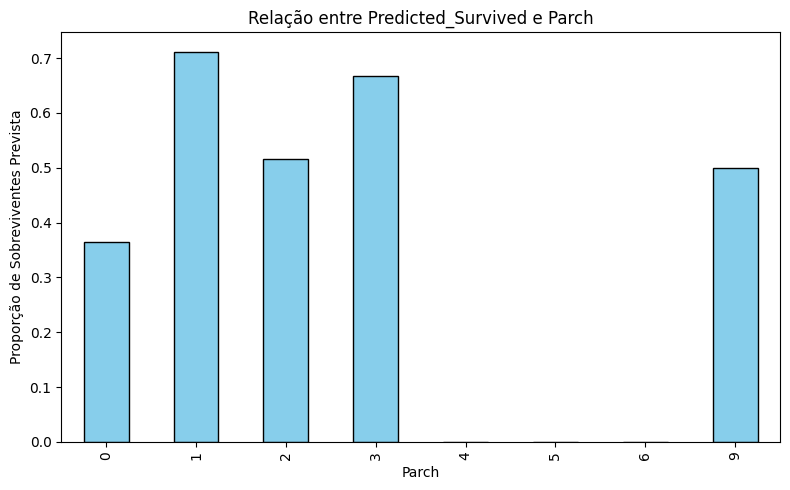

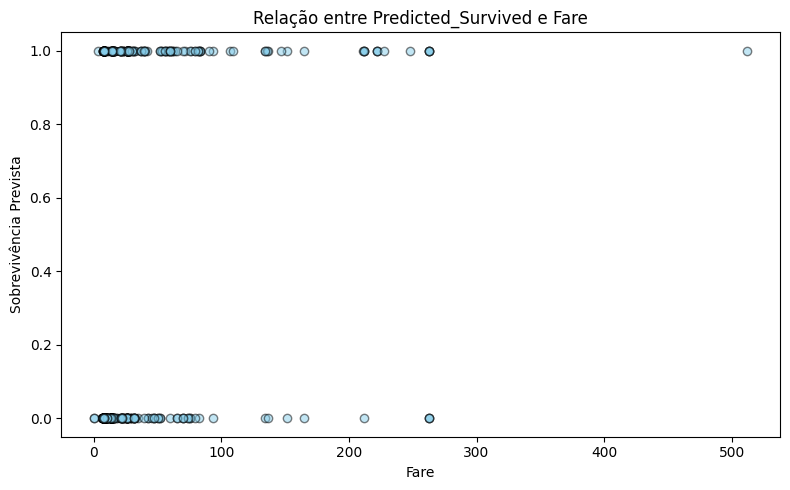

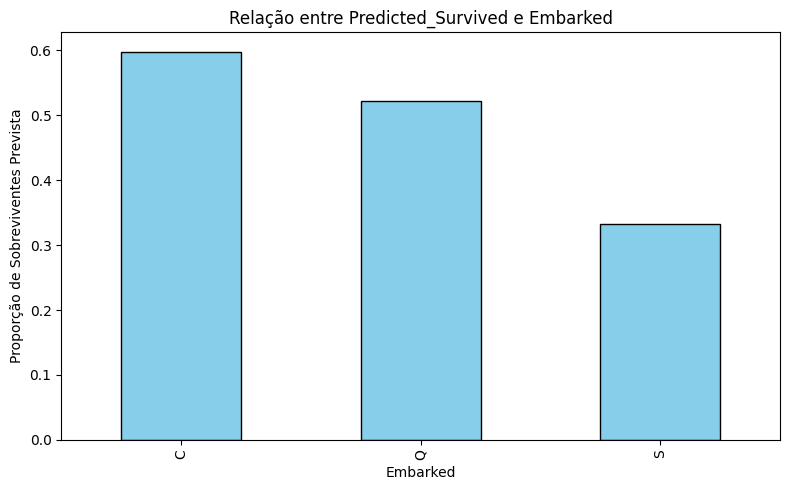

In [25]:
# Avaliação no conjunto de teste
test_df = pd.read_csv("test.csv")
X_test = test_df[features].copy()
X_test = pd.get_dummies(X_test, columns=['Sex', 'Embarked'], drop_first=True)
X_test['Age'] = X_test['Age'].fillna(X_test['Age'].median())
X_test['Fare'] = X_test['Fare'].fillna(X_test['Fare'].median())
X_test_scaled = scaler.transform(X_test)

# Previsão no conjunto de teste
y_test_pred = best_mlp.predict(X_test_scaled)
y_test_pred_proba = best_mlp.predict_proba(X_test_scaled)

# Exibindo as previsões
test_df['Predicted_Survived'] = y_test_pred
print("Previsões de sobrevivência adicionadas ao conjunto de teste:")
print(test_df[['Predicted_Survived']].head())

# Plotando distribuição de probabilidades
plt.figure(figsize=(8,5))
plt.hist(y_test_pred_proba[:, 1], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribuição de Probabilidades - Teste')
plt.xlabel('Probabilidade de Sobrevivência')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

# Plotando relação entre 'Predicted_Survived' e cada feature
for feature in features:
    plt.figure(figsize=(8,5))
    if feature in ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']:  # Features categóricas
        test_df.groupby(feature)['Predicted_Survived'].mean().plot(kind='bar', color='skyblue', edgecolor='black')
        plt.ylabel('Proporção de Sobreviventes Prevista')
    else:  # Features numéricas
        plt.scatter(test_df[feature], test_df['Predicted_Survived'], alpha=0.5, color='skyblue', edgecolor='black')
        plt.ylabel('Sobrevivência Prevista')
    plt.title(f'Relação entre Predicted_Survived e {feature}')
    plt.xlabel(feature)
    plt.tight_layout()
    plt.show()

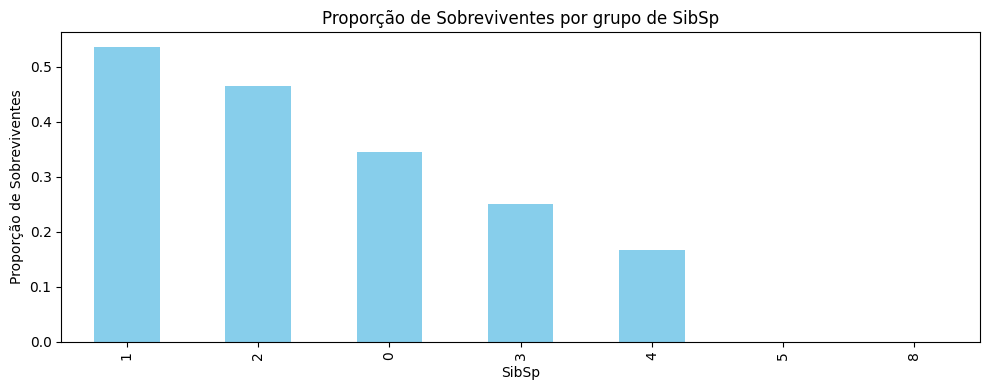

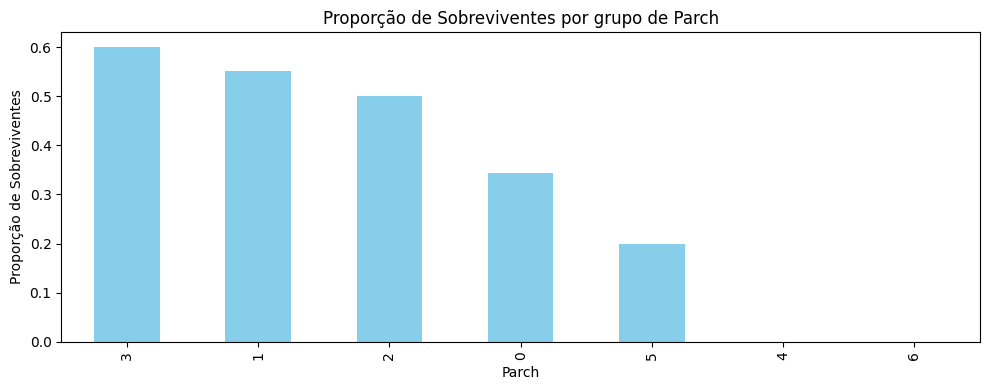

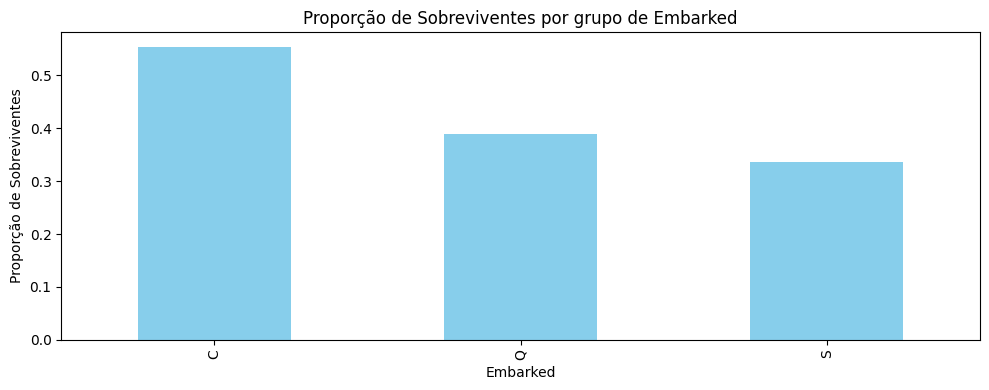

<Figure size 1000x600 with 0 Axes>

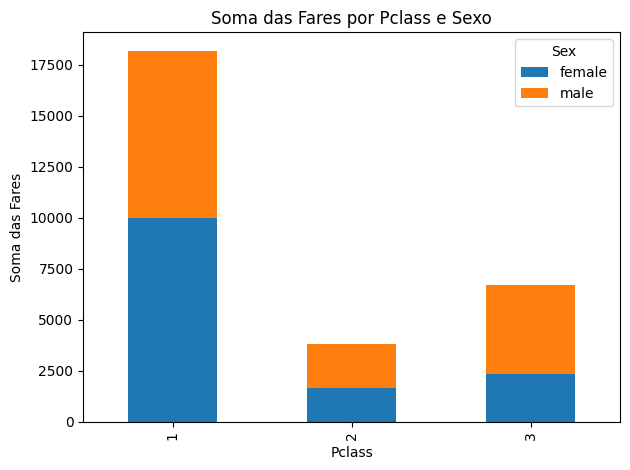

<Figure size 1000x600 with 0 Axes>

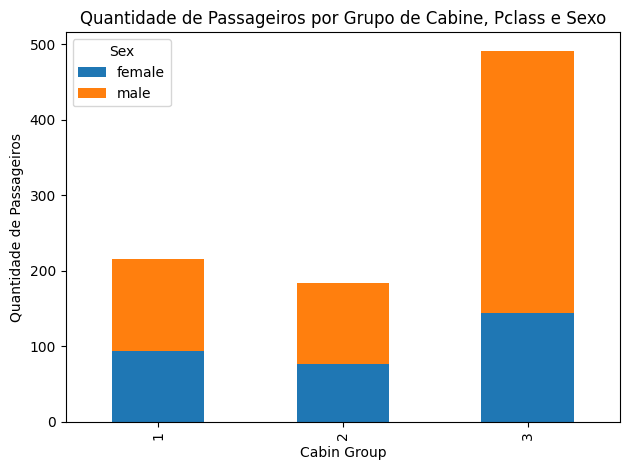

In [26]:
import matplotlib.pyplot as plt

# 4. Análise dos grupos SibSp, Parch, Ticket, Embarked com plots
for col in ['SibSp', 'Parch', 'Embarked']:
    group_surv = train_df.groupby(col)['Survived'].mean().sort_values(ascending=False)
    plt.figure(figsize=(10,4))
    group_surv.plot(kind='bar', color='skyblue')
    plt.title(f'Proporção de Sobreviventes por grupo de {col}')
    plt.xlabel(col)
    plt.ylabel('Proporção de Sobreviventes')
    plt.tight_layout()
    plt.show()

# Para Fare: plotar quantidade de passageiros por Pclass e Sex
plt.figure(figsize=(10,6))
train_df.groupby(['Pclass', 'Sex'])['Fare'].sum().unstack().plot(kind='bar', stacked=True)
plt.title('Soma das Fares por Pclass e Sexo')
plt.ylabel('Soma das Fares')
plt.xlabel('Pclass')
plt.tight_layout()
plt.show()

# Para Cabin: plotar quantidade de passageiros por Pclass e Sex
plt.figure(figsize=(10,6))
train_df['Cabin_group'] = train_df['Cabin'].astype(str).str[0]  # Agrupa por letra inicial da cabine
cabin_counts = train_df.groupby(['Cabin_group', 'Pclass', 'Sex']).size().unstack(['Sex']).fillna(0)
cabin_counts.groupby('Pclass').sum().plot(kind='bar', stacked=True)
plt.title('Quantidade de Passageiros por Grupo de Cabine, Pclass e Sexo')
plt.ylabel('Quantidade de Passageiros')
plt.xlabel('Cabin Group')
plt.tight_layout()
plt.show()

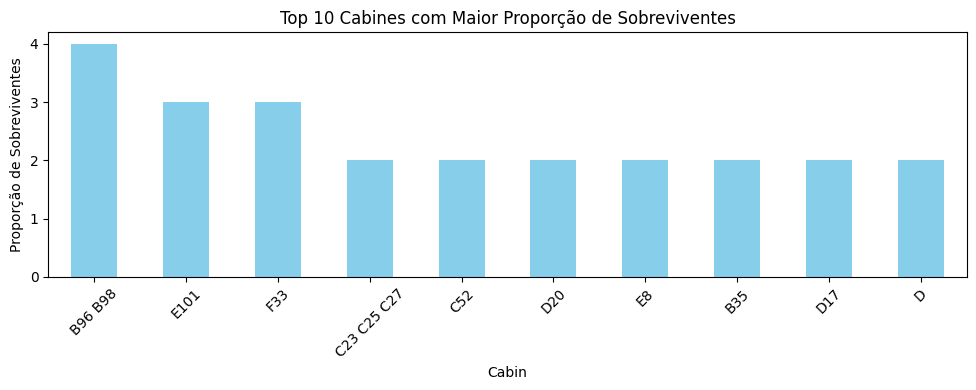

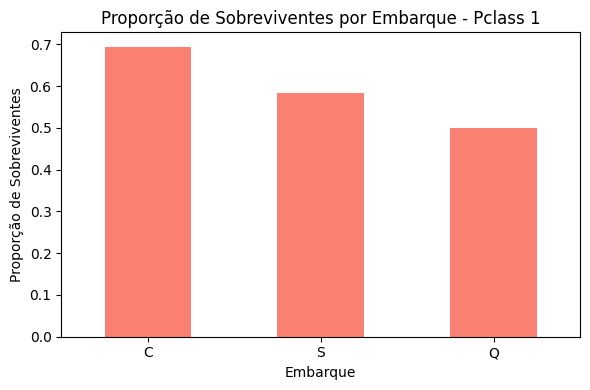

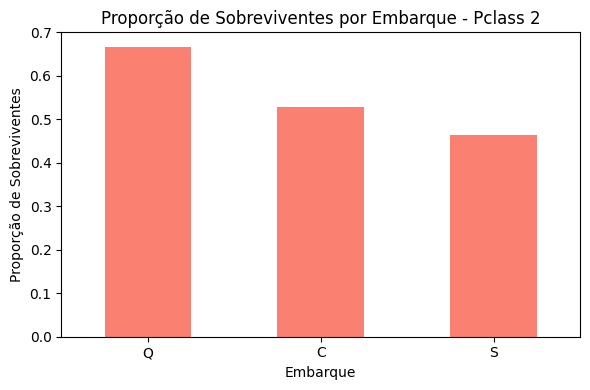

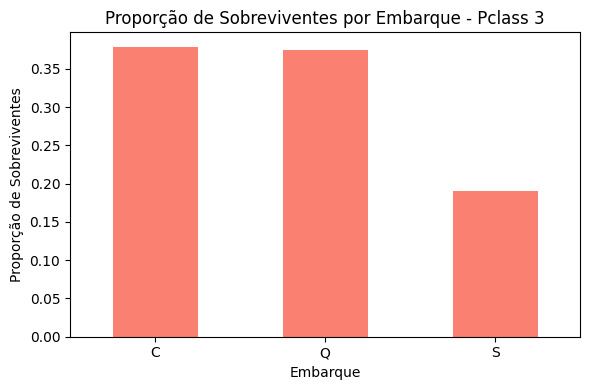

<Figure size 800x500 with 0 Axes>

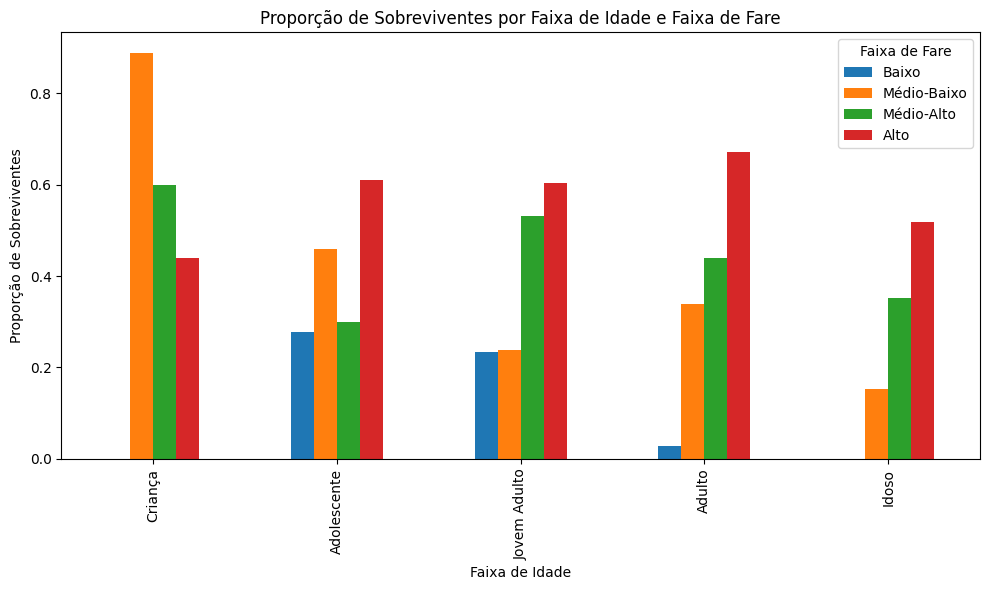

In [27]:
# Análise: Cabines com mais sobreviventes
cabine_surv = train_df.groupby('Cabin')['Survived'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,4))
cabine_surv.plot(kind='bar', color='skyblue')
plt.title('Top 10 Cabines com Maior Proporção de Sobreviventes')
plt.xlabel('Cabin')
plt.ylabel('Proporção de Sobreviventes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Análise: Embarque com mais sobreviventes por Pclass
for pclass in sorted(train_df['Pclass'].unique()):
    plt.figure(figsize=(6,4))
    emb = train_df[train_df['Pclass']==pclass].groupby('Embarked')['Survived'].mean().sort_values(ascending=False)
    emb.plot(kind='bar', color='salmon')
    plt.title(f'Proporção de Sobreviventes por Embarque - Pclass {pclass}')
    plt.xlabel('Embarque')
    plt.ylabel('Proporção de Sobreviventes')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Análise: Faixas de Fare e Ages que mais sobreviveram
fare_bins = pd.qcut(train_df['Fare'], q=4, labels=['Baixo','Médio-Baixo','Médio-Alto','Alto'])
age_bins = pd.cut(train_df['Age'], bins=[0,12,18,30,50,80], labels=['Criança','Adolescente','Jovem Adulto','Adulto','Idoso'])
fare_age_surv = train_df.copy()
fare_age_surv['FareBin'] = fare_bins
fare_age_surv['AgeBin'] = age_bins
plt.figure(figsize=(8,5))
surv_pivot = fare_age_surv.pivot_table(index='AgeBin', columns='FareBin', values='Survived', aggfunc='mean')
surv_pivot.plot(kind='bar', figsize=(10,6))
plt.title('Proporção de Sobreviventes por Faixa de Idade e Faixa de Fare')
plt.ylabel('Proporção de Sobreviventes')
plt.xlabel('Faixa de Idade')
plt.legend(title='Faixa de Fare')
plt.tight_layout()
plt.show()

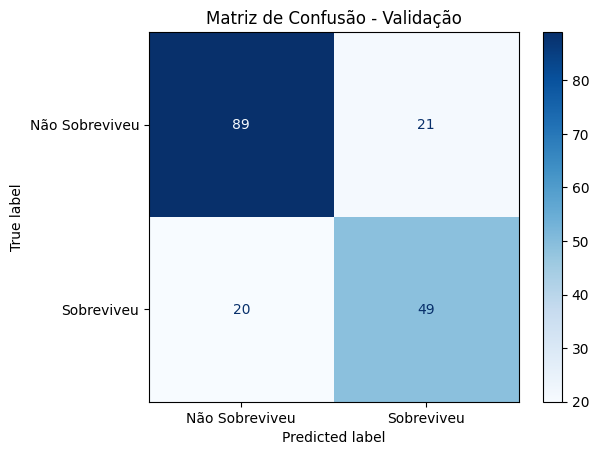

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Sobreviveu', 'Sobreviveu'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão - Validação')
plt.show()

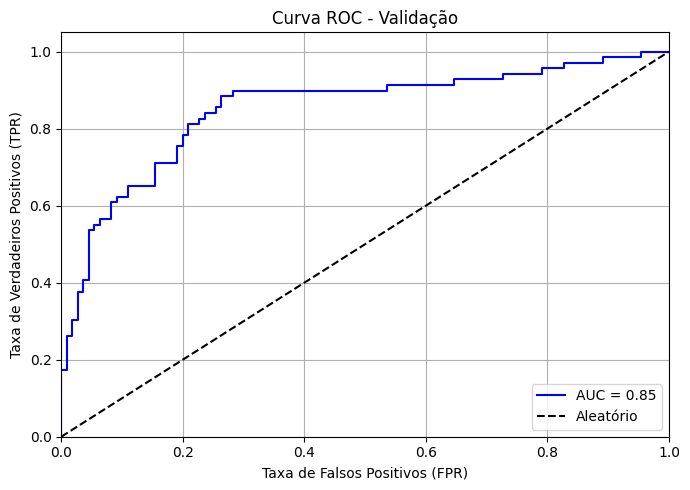

In [29]:
from sklearn.metrics import roc_curve, auc

y_val_proba = best_mlp.predict_proba(X_val_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Validação')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

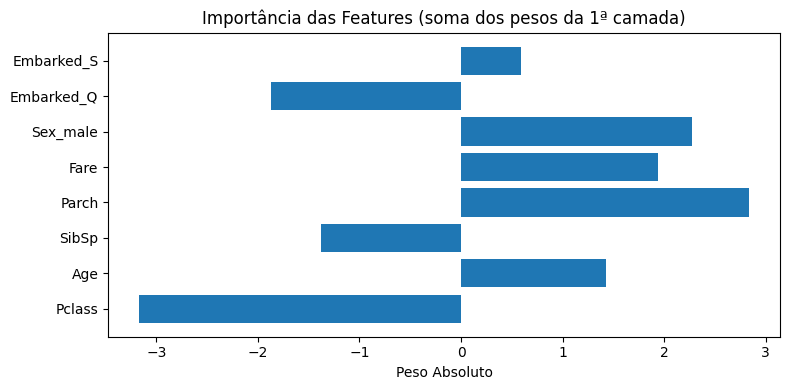

In [30]:
importances = best_mlp.coefs_[0].sum(axis=1)
feature_names = X_train.columns
plt.figure(figsize=(8,4))
plt.barh(feature_names, importances)
plt.title('Importância das Features (soma dos pesos da 1ª camada)')
plt.xlabel('Peso Absoluto')
plt.tight_layout()
plt.show()

In [31]:
val_results = X_val.copy()
val_results['y_true'] = y_val.values
val_results['y_pred'] = val_pred
erros = val_results[val_results['y_true'] != val_results['y_pred']]
print('Exemplos de erros do modelo:')
print(erros.head())

Exemplos de erros do modelo:
     Pclass   Age  SibSp  Parch      Fare  Sex_male  Embarked_Q  Embarked_S  \
553       3  22.0      0      0    7.2250      True       False       False   
536       1  45.0      0      0   26.5500      True       False        True   
698       1  49.0      1      1  110.8833      True       False       False   
817       2  31.0      1      1   37.0042      True       False       False   
455       3  29.0      0      0    7.8958      True       False       False   

     y_true  y_pred  
553       1       0  
536       0       1  
698       0       1  
817       0       1  
455       1       0  


In [32]:
val_results['Sex'] = train_df.loc[X_val.index, 'Sex']
for group in val_results['Sex'].unique():
    mask = val_results['Sex'] == group
    acc = (val_results.loc[mask, 'y_true'] == val_results.loc[mask, 'y_pred']).mean()
    print(f'Acurácia para {group}: {acc:.2f}')

Acurácia para male: 0.75
Acurácia para female: 0.82


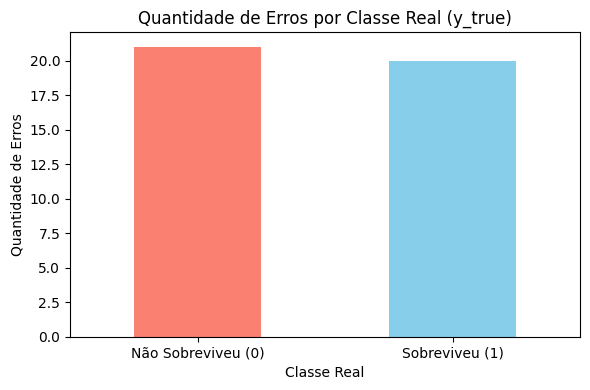

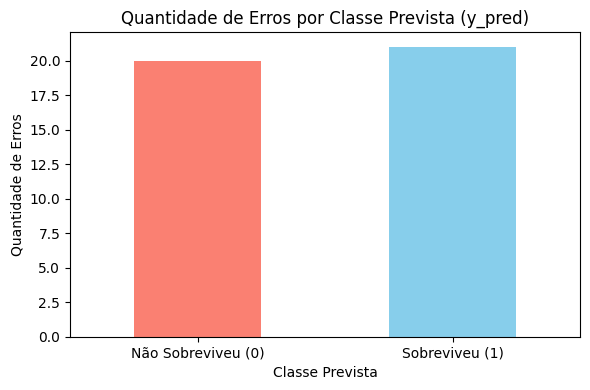

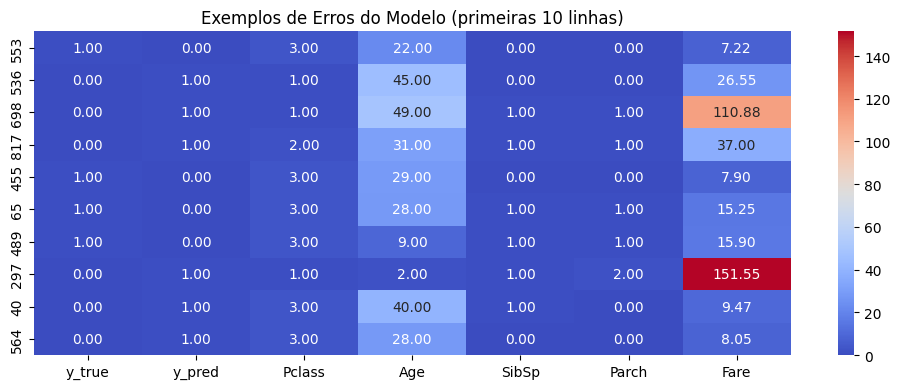

In [33]:
# Análise dos erros do modelo com plot
val_results = X_val.copy()
val_results['y_true'] = y_val.values
val_results['y_pred'] = val_pred
val_results['erro'] = val_results['y_true'] != val_results['y_pred']

import matplotlib.pyplot as plt
import seaborn as sns

# Plotando a contagem de erros por classe real (y_true)
plt.figure(figsize=(6,4))
val_results[val_results['erro']].groupby('y_true').size().plot(kind='bar', color=['salmon', 'skyblue'])
plt.title('Quantidade de Erros por Classe Real (y_true)')
plt.xlabel('Classe Real')
plt.ylabel('Quantidade de Erros')
plt.xticks([0,1], ['Não Sobreviveu (0)', 'Sobreviveu (1)'], rotation=0)
plt.tight_layout()
plt.show()

# Plotando a contagem de erros por classe prevista (y_pred)
plt.figure(figsize=(6,4))
val_results[val_results['erro']].groupby('y_pred').size().plot(kind='bar', color=['salmon', 'skyblue'])
plt.title('Quantidade de Erros por Classe Prevista (y_pred)')
plt.xlabel('Classe Prevista')
plt.ylabel('Quantidade de Erros')
plt.xticks([0,1], ['Não Sobreviveu (0)', 'Sobreviveu (1)'], rotation=0)
plt.tight_layout()
plt.show()

# Seleciona apenas colunas numéricas e as classes para o heatmap
cols_to_show = ['y_true', 'y_pred']
for col in ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']:
    if col in val_results.columns:
        cols_to_show.append(col)

# Garante que só vai valores numéricos
heatmap_data = val_results[val_results['erro']].head(10)[cols_to_show].astype(float)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Exemplos de Erros do Modelo (primeiras 10 linhas)')
plt.tight_layout()
plt.show()

### Referências bibliográficas

- KAGGLE. Titanic - Machine Learning from Disaster. Disponível em: <https://www.kaggle.com/c/titanic>. Acesso em: 04 jul. 2025.

- TAVARES, Lucas. Dados desbalanceados: o que são e como evitá-los. *Turing Talks*, Medium, 2020. Disponível em: <https://medium.com/turing-talks/dados-desbalanceados-o-que-s%C3%A3o-e-como-evit%C3%A1-los-43df4f49732b>. Acesso em: 04 jul. 2025.

- Pandas: Python Data Analysis Library. Disponível em: <https://pandas.pydata.org/>. Acesso em: 04 jul. 2025.

- Scikit-learn: Machine Learning in Python. Disponível em: <https://scikit-learn.org/stable/>. Acesso em: 04 jul. 2025.